In [1]:
%load_ext autoreload
%autoreload 2
import os
import copy
import scipy
import numpy as np
import matplotlib.pyplot as plt

from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.stats import sigma_clip
from astropy.coordinates import SkyCoord
import astropy.units as u

In [2]:
from lvhuo.stack import Stack, StackSky
from lvhuo.display import (display_single, display_multiple, \
                           draw_circles, draw_rectangles, SEG_CMAP)
from lvhuo.image import query_star, extract_obj

In [15]:
skyobj = Table.read('interpmethod_skyobj.fits', format='fits')[0]

from unagi import hsc
from unagi import mask
from unagi.task import hsc_cutout, hsc_tricolor, hsc_psf, hsc_check_coverage
from unagi.sky import SkyObjs, AperPhot, S18A_APER, S18A_APER_ID

# Setup HSC server
s18a = hsc.Hsc(dr='dr2', rerun='s18a_wide', verbose=False)
obj_coor = SkyCoord(29.41898541, -4.70075704, unit='deg')
hdu = hsc_cutout(obj_coor, cutout_size=4 * u.arcmin, archive=s18a, 
                 filters='r', mask=True)
simg = Stack(hdu[1].data, header=hdu[1].header)
simg.hscmask = hdu[2].data
simg.mask = mask.Mask(simg.hscmask, data_release='s18a').extract('DETECTED').astype(float)
hdu.close()

# Retrieving cutout image in filter: r


# The followings are some comparisons of interpolation methods

### Different interpolation methods

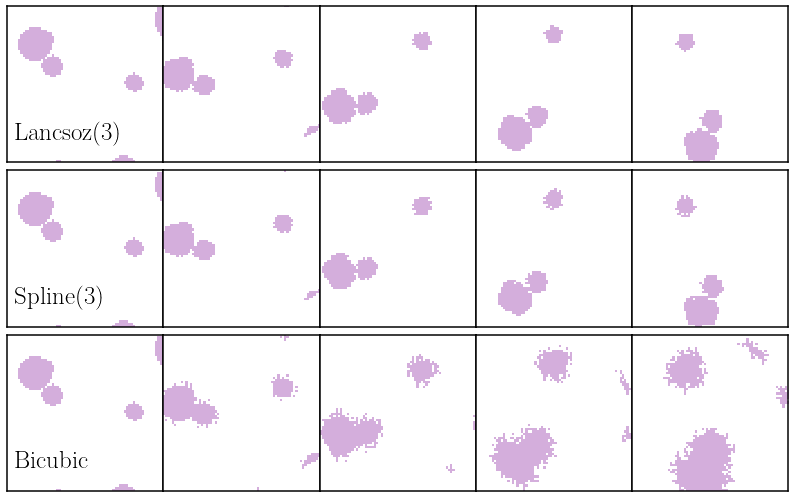

In [16]:
fig, ax = plt.subplots(3, 5, figsize=(14, 9))

ssky = StackSky(simg.image, simg.header, skyobj, mask=simg.mask, aper_name='aper118')
data_set = []
data_set.append(ssky.mask.astype(float))
for i in range(4):
    ssky.rotate_mask(30, order=5, method='lanczos')
    rtmask = ssky.mask
    data_set.append(rtmask.astype(float))

display_multiple(data_set, scale_bar=False, ax=ax[0, :], scale='linear', cmap=SEG_CMAP);
ax[0, 0].text(3, 10, r'$\mathrm{Lancsoz(3)}$')

ssky = StackSky(simg.image, simg.header, skyobj, mask=simg.mask, aper_name='aper118')
data_set = []
data_set.append(ssky.mask.astype(float))
for i in range(4):
    ssky.rotate_mask(30, order=3, method='spline')
    rtmask = ssky.mask
    data_set.append(rtmask.astype(float))

display_multiple(data_set, scale_bar=False, ax=ax[1, :], scale='linear', cmap=SEG_CMAP);
ax[1, 0].text(3, 10, r'$\mathrm{Spline(3)}$')

ssky = StackSky(simg.image, simg.header, skyobj, mask=simg.mask, aper_name='aper118')
data_set = []
data_set.append(ssky.mask.astype(float))
for i in range(4):
    ssky.rotate_mask(30, order=3, method='bicubic')
    rtmask = ssky.mask
    data_set.append(rtmask.astype(float))

display_multiple(data_set, scale_bar=False, ax=ax[2, :], scale='linear', cmap=SEG_CMAP);
ax[2, 0].text(3, 10, r'$\mathrm{Bicubic}$')

plt.subplots_adjust(hspace=0.02, wspace=0.0)

### Different orders of interpolation

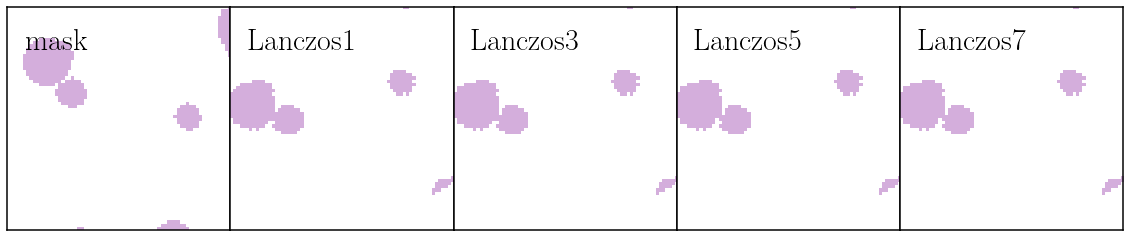

In [24]:
data_set = []
ssky = StackSky(simg.image, simg.header, skyobj, mask=simg.mask, aper_name='aper118')
data_set.append(ssky.mask)
for i in range(4):
    ssky = StackSky(simg.image, simg.header, skyobj, mask=simg.mask, aper_name='aper118')
    ssky.rotate_mask(30, method='lanczos', order=2*i + 1)
    data_set.append(ssky.mask)
    
display_multiple(data_set, scale_bar=False, scale='linear', cmap=SEG_CMAP,
                 text=['mask', 'Lanczos1', 'Lanczos3', 'Lanczos5', 'Lanczos7'], text_color='k');
#plt.savefig('./lanczos_mask.png', dpi=100, bbox_inches='tight')

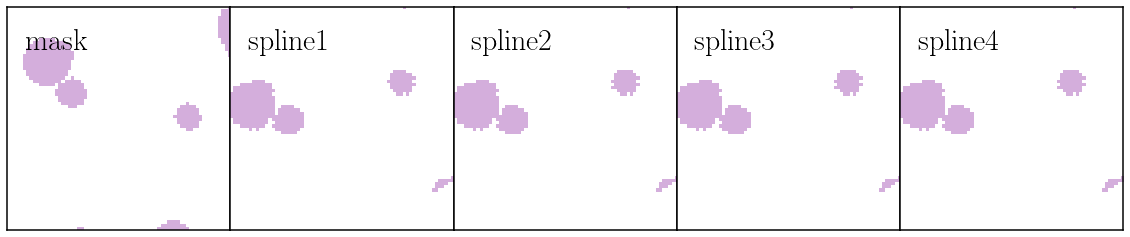

In [25]:
data_set = []
ssky = StackSky(simg.image, simg.header, skyobj, mask=simg.mask, aper_name='aper118')
data_set.append(ssky.mask)
for i in range(4):
    ssky = StackSky(simg.image, simg.header, skyobj, mask=simg.mask, aper_name='aper118')
    ssky.rotate_mask(30, method='spline', order=i + 1)
    data_set.append(ssky.mask)
    
display_multiple(data_set, scale_bar=False, scale='linear', cmap=SEG_CMAP,
                 text=['mask', 'spline1', 'spline2', 'spline3', 'spline4'], text_color='k');
#plt.savefig('./lanczos_mask.png', dpi=100, bbox_inches='tight')

# Test WCS

In [355]:
from lvhuo.image import img_cutout

In [452]:
from astropy.nddata import block_reduce, block_replicate

In [694]:
hdu = fits.open('./Images/dr2_s18a_wide_129.6827_-0.0397_2.00arcmin_i.fits')
img = hdu[1].data
img_hdr = hdu[1].header
w = wcs.WCS(hdu[1].header)
simg = Stack(img, header=img_hdr)

In [697]:
simg.resize_Stack(2, method='lanczos');

In [ ]:
ax1 = fig.add_subplot(2, 2, 1)

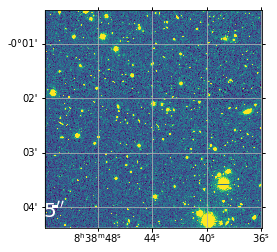

In [855]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=simg.wcs)
display_single(simg.image, ax=ax)
plt.grid('on')

## Try register without `iraf`!

In [856]:
hdu1 = fits.open('./Images/n5907_df_r.fits')
hdu2 = fits.open('./Images/n5907_cfht_r.fits')

In [859]:
s_df = Stack(hdu1[0].data, header=hdu1[0].header)
s_df.resize_image(3)
#s_df.save_to_fits('./Images/df_3.fits');

array([[ 46.61997 ,  67.03778 ,  75.76721 , ...,  76.41452 ,  67.64169 ,
         47.05109 ],
       [ 67.02543 ,  96.38551 , 108.942764, ..., 109.81175 ,  97.183205,
         67.59005 ],
       [ 75.72728 , 108.90605 , 123.101906, ..., 123.9789  , 109.68503 ,
         76.26829 ],
       ...,
       [ 82.15648 , 118.195656, 133.68486 , ..., 124.69027 , 110.460846,
         76.86846 ],
       [ 72.15852 , 103.7764  , 117.32396 , ..., 110.22933 ,  97.62367 ,
         67.9208  ],
       [ 49.816517,  71.63591 ,  80.97987 , ...,  76.640945,  67.86533 ,
         47.210323]], dtype=float32)

In [860]:
s_df.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 229.376616664047  56.2789354116981  
CRPIX : 1797.0  1389.0  
CD1_1 CD1_2  : -7.716049382715667e-05  0.0  
CD2_1 CD2_2  : 0.0  7.716049382715667e-05  
NAXIS : 3597  2778

In [814]:
np.array(hdu1[0].data.shape) * 3

array([2778, 3597])

In [842]:
s_cfht = Stack(hdu2[0].data, header=hdu2[0].header)